<h1>LSTM Fine Tune Layers<h1>

<h4>Data Cleaning<h4>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from IPython.core.interactiveshell import InteractiveShell
from sklearn.model_selection import KFold
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline
sns.set()
pd.options.display.max_rows = 100

df = pd.read_csv('.\Datasets\CR_COST_FC_new.csv', converters={'PARTY_ID': str, 'COM_ID': str, 'CNTR_SIZE': str})
df['POD'] = pd.to_datetime(df['POD'])
df['ENCODED_TYPE'] = df['ENCODED_TYPE'].fillna(-1).astype(int)
df = df.dropna(subset=['ENCODED_TYPE'])
df['RATE'] = df['RATE'].fillna(-1).astype(int)
df = df.dropna(subset=['RATE'])
df['ENCODED_TYPE'] = df['ENCODED_TYPE'].astype(int)

# Remove NAN values
df_clean= df.dropna().reset_index(drop=True)

df_clean.head()
df_clean.info()
print(f'Dataset size: {df_clean.shape}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54722 entries, 0 to 54721
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   COM_ID        54722 non-null  object        
 1   PARTY_ID      54722 non-null  object        
 2   PARTY_ID_EN   54722 non-null  int64         
 3   PARTY_NAME    54722 non-null  object        
 4   CSL_ID        54722 non-null  object        
 5   ETA_ETD_NO    54722 non-null  int64         
 6   ETD_POL_D     54722 non-null  object        
 7   POD_ID        54722 non-null  object        
 8   POD           54722 non-null  datetime64[ns]
 9   CNTR_ID       54722 non-null  object        
 10  CNTR_SIZE     54722 non-null  object        
 11  CNTR_TYPE     54722 non-null  object        
 12  COST_TERM     54722 non-null  object        
 13  RATE          54722 non-null  int32         
 14  ENCODED_TYPE  54722 non-null  int32         
 15  ENCODED_TERM  54722 non-null  int64 

In [2]:
sel_col = ['CSL_ID', 'CNTR_ID','POD_ID','ETD_POL_D','PARTY_ID',
           'PARTY_NAME','POD','CNTR_SIZE','CNTR_TYPE','RATE']

df_fc = df_clean[sel_col]

# filter out rows where the year is 2002
df_filtered = df_fc[df_fc['POD'].dt.year != 2002]

# Checking if year 2002 is removed
df_filtered['POD'].dt.year.unique()

# Sorting the dates 
df_filtered = df_filtered.sort_values(by='POD').reset_index(drop=True)

array([2006, 2005, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015,
       2018, 2019, 2020, 2021, 2016, 2017, 2022, 2023], dtype=int64)

<h4>FIltering and getting a list stored as a dictionary</h4>

In [4]:
def filter_dataframe(df):
    filtered_dataframes = {}

    for (port, size, ctype, party_id), group in df.groupby(['POD_ID', 'CNTR_SIZE', 'CNTR_TYPE', 'PARTY_ID']):
        group = group.reset_index(drop=True).sort_values(by='POD')
        df_id = f"Port_{port}_Size_{size}_Type_{ctype}_PartyID_{party_id}"
        filtered_dataframes[df_id] = group

    return filtered_dataframes

In [5]:
filtered_dataframes = filter_dataframe(df_filtered)

# Show case some samples of keys
df_ids = list(filtered_dataframes.keys())
print(list(df_ids))
print(len(list(df_ids)))

['Port_(CONSTANZA)_Size_40_Type_GP_PartyID_010007816', 'Port_(CONSTANZA)_Size_40_Type_HC_PartyID_010007816', 'Port_AARHUS_Size_20_Type_GP_PartyID_01000043', 'Port_AARHUS_Size_20_Type_GP_PartyID_0100027830', 'Port_AARHUS_Size_20_Type_GP_PartyID_0100028193', 'Port_AARHUS_Size_20_Type_GP_PartyID_010006666', 'Port_AARHUS_Size_40_Type_GP_PartyID_01000043', 'Port_AARHUS_Size_40_Type_HC_PartyID_01000043', 'Port_AARHUS_Size_40_Type_HC_PartyID_0100027830', 'Port_AARHUS_Size_40_Type_HC_PartyID_0100028193', 'Port_AARHUS_Size_40_Type_HC_PartyID_010006666', 'Port_ABIDJAN_Size_20_Type_GP_PartyID_0100027878', 'Port_ABIDJAN_Size_40_Type_HC_PartyID_010021097', 'Port_ADELAIDE_Size_20_Type_GP_PartyID_01002775', 'Port_ADELAIDE_Size_40_Type_GP_PartyID_01002775', 'Port_ADELAIDE_Size_40_Type_HC_PartyID_01002775', 'Port_ADELAIDE_Size_40_Type_HC_PartyID_01005078', 'Port_ADELAIDE_Size_40_Type_HC NOR_PartyID_01002775', 'Port_ADELAIDE(AU)_Size_20_Type_GP_PartyID_01002775', 'Port_ADELAIDE(AU)_Size_40_Type_HC_Party

<h4>Getting the top 5 ports</h4>

In [6]:
# Get a dictionary with key and number of rows for each dataframe in filtered_dataframes
key_row_counts = {key: len(filtered_dataframes[key]) for key in filtered_dataframes}

# Sort the key_row_counts dictionary by value (number of rows) in descending order
sorted_key_row_counts = sorted(key_row_counts.items(), key=lambda item: item[1], reverse=True)
# print(sorted_key_row_counts)

# Get the top 5 keys with the most rows
top_5_keys_tuple = sorted_key_row_counts[:5]
# print(top_5_keys_tuple)

# Create a dictionary with the top 5 keys and their corresponding dataframes (with up to 5 rows per dataframe)
filtered_dataframes_subset = {}

for key, row_count in top_5_keys_tuple:
    filtered_dataframes_subset[key] = filtered_dataframes[key][:5]
    print(f"Number of rows in {key}: {row_count}")

# print(filtered_dataframes_subset.keys())

Number of rows in Port_BUSAN_Size_40_Type_HC_PartyID_010004286: 1712
Number of rows in Port_AUCKLAND_Size_40_Type_HC_PartyID_01005136: 1704
Number of rows in Port_MELBOURNE_Size_40_Type_HC_PartyID_01002778: 1341
Number of rows in Port_SYDNEY_Size_40_Type_HC_PartyID_01002779: 1308
Number of rows in Port_DUBAI (JEBEL ALI)_Size_40_Type_HC_PartyID_01002788: 1070


In [7]:
# Selected dataframe
sel_df = filtered_dataframes['Port_BUSAN_Size_40_Type_HC_PartyID_010004286']
sel_df.head()
sel_df.info()

,CSL_ID,CNTR_ID,POD_ID,ETD_POL_D,PARTY_ID,PARTY_NAME,POD,CNTR_SIZE,CNTR_TYPE,RATE
0,ECS010050800407,CTNR010050901151,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2005-10-03,40,HC,390
1,ECS010050800407,CTNR010050901379,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2005-10-03,40,HC,390
2,ECS010050900468,CTNR010051000081,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2005-10-07,40,HC,390
3,ECS010050900468,CTNR010050901461,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2005-10-07,40,HC,390
4,ECS010050900469,CTNR010051000434,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2005-10-14,40,HC,390


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1712 entries, 0 to 1711
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   CSL_ID      1712 non-null   object        
 1   CNTR_ID     1712 non-null   object        
 2   POD_ID      1712 non-null   object        
 3   ETD_POL_D   1712 non-null   object        
 4   PARTY_ID    1712 non-null   object        
 5   PARTY_NAME  1712 non-null   object        
 6   POD         1712 non-null   datetime64[ns]
 7   CNTR_SIZE   1712 non-null   object        
 8   CNTR_TYPE   1712 non-null   object        
 9   RATE        1712 non-null   int32         
dtypes: datetime64[ns](1), int32(1), object(8)
memory usage: 140.4+ KB


In [9]:
# Check for duplicates and keep only one instance of each unique combination
sel_df = sel_df.drop_duplicates(subset=['POD', 'RATE']).reset_index(drop=True)

# Initialize the reference date with the first date in the "POD" column
reference_date = sel_df['POD'].iloc[0]

# Calculate the difference in days and print it out
for index, date in enumerate(sel_df['POD']):
    if index > 0:
        prev_date = sel_df['POD'].iloc[index - 1]
        days_difference = (date - prev_date).days
        print(f"Difference between {prev_date}and {date}: {days_difference} days")

# Formating by month
# Create new dataframe for aggregated results
agg_df = pd.DataFrame(columns=['YearMonth', 'Year', 'Month', 'Rate'])

# Group by Year and Month
grouped = sel_df.groupby([sel_df['POD'].dt.year, sel_df['POD'].dt.month])

for group_name, group_df in grouped:
    year, month = group_name
    
    # Calculate sum and skewness of RATE values
    rate_sum = group_df['RATE'].sum()
    rate_skew = group_df['RATE'].skew()
    
    # Calculate mean or median based on skewness
    if rate_skew < 0:
        rate_metric = group_df['RATE'].mean()
    else:
        rate_metric = group_df['RATE'].median()
    
    new_row = {
        'YearMonth': pd.Timestamp(year=year, month=month, day=1),
        'Year': year,
        'Month': month,
        'Rate': rate_metric
    }
    
    # Append row to aggregated dataframe
    agg_df = agg_df.append(new_row, ignore_index=True)
    
agg_df['YearMonth_en'] = agg_df["YearMonth"].dt.strftime('%Y%m%d').astype(int)

agg_df.head(10)
agg_df.info()

Difference between 2005-10-03 00:00:00and 2005-10-07 00:00:00: 4 days
Difference between 2005-10-07 00:00:00and 2005-10-14 00:00:00: 7 days
Difference between 2005-10-14 00:00:00and 2005-10-30 00:00:00: 16 days
Difference between 2005-10-30 00:00:00and 2005-11-03 00:00:00: 4 days
Difference between 2005-11-03 00:00:00and 2005-11-12 00:00:00: 9 days
Difference between 2005-11-12 00:00:00and 2005-11-28 00:00:00: 16 days
Difference between 2005-11-28 00:00:00and 2005-12-04 00:00:00: 6 days
Difference between 2005-12-04 00:00:00and 2005-12-10 00:00:00: 6 days
Difference between 2005-12-10 00:00:00and 2005-12-31 00:00:00: 21 days
Difference between 2005-12-31 00:00:00and 2006-01-07 00:00:00: 7 days
Difference between 2006-01-07 00:00:00and 2006-02-04 00:00:00: 28 days
Difference between 2006-02-04 00:00:00and 2006-02-10 00:00:00: 6 days
Difference between 2006-02-10 00:00:00and 2006-02-17 00:00:00: 7 days
Difference between 2006-02-17 00:00:00and 2006-02-24 00:00:00: 7 days
Difference betwe

C:\Users\Aloysius Wong\AppData\Local\Temp\ipykernel_27328\1622839181.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  agg_df = agg_df.append(new_row, ignore_index=True)
C:\Users\Aloysius Wong\AppData\Local\Temp\ipykernel_27328\1622839181.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  agg_df = agg_df.append(new_row, ignore_index=True)
C:\Users\Aloysius Wong\AppData\Local\Temp\ipykernel_27328\1622839181.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  agg_df = agg_df.append(new_row, ignore_index=True)
C:\Users\Aloysius Wong\AppData\Local\Temp\ipykernel_27328\1622839181.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  agg

,YearMonth,Year,Month,Rate,YearMonth_en
0,2005-10-01,2005,10,390.0,20051001
1,2005-11-01,2005,11,390.0,20051101
2,2005-12-01,2005,12,390.0,20051201
3,2006-01-01,2006,1,390.0,20060101
4,2006-02-01,2006,2,390.0,20060201
5,2006-03-01,2006,3,385.0,20060301
6,2006-04-01,2006,4,380.0,20060401
7,2006-05-01,2006,5,380.0,20060501
8,2006-08-01,2006,8,380.0,20060801
9,2006-09-01,2006,9,380.0,20060901


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185 entries, 0 to 184
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   YearMonth     185 non-null    datetime64[ns]
 1   Year          185 non-null    object        
 2   Month         185 non-null    object        
 3   Rate          185 non-null    float64       
 4   YearMonth_en  185 non-null    int32         
dtypes: datetime64[ns](1), float64(1), int32(1), object(2)
memory usage: 6.6+ KB


<h4>Mean Square Error Evaluation Function</h4>

In [10]:
# Mean Square Error Function:
def calculate_RMSE(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

<h4>LSTM Regression<h4>

In [11]:
# Dataframe for LSTM
df_lstm1 = agg_df[['YearMonth','Rate']]
df_lstm1.head()
df_lstm1.info()

,YearMonth,Rate
0,2005-10-01,390.0
1,2005-11-01,390.0
2,2005-12-01,390.0
3,2006-01-01,390.0
4,2006-02-01,390.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185 entries, 0 to 184
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   YearMonth  185 non-null    datetime64[ns]
 1   Rate       185 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 3.0 KB


In [19]:
# Restructure time series data for LSTM model
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

def create_LSTM_model(trainX, trainY, testX, testY, epochs):
    # LSTM model
    model = Sequential()
    model.add(LSTM(2, input_shape=(trainX.shape[1], trainX.shape[2]), activation='tanh', recurrent_activation='hard_sigmoid'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')

    # Fit the model and store the history
    history = model.fit(trainX, trainY, epochs=epochs, batch_size=1, verbose=2, validation_data=(testX, testY))
    return model, history

def plot_train_val_loss(history):
    plt.figure(figsize=(10,6))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model loss progress during training and validation')
    plt.xlabel('Epoch')
    plt.ylabel('Training and Validation Loss')
    plt.legend()
    plt.show()


Training for 50 epochs...
Epoch 1/50
109/109 - 2s - loss: 0.1010 - val_loss: 0.0980 - 2s/epoch - 18ms/step
Epoch 2/50
109/109 - 0s - loss: 0.0603 - val_loss: 0.0695 - 205ms/epoch - 2ms/step
Epoch 3/50
109/109 - 0s - loss: 0.0382 - val_loss: 0.0555 - 204ms/epoch - 2ms/step
Epoch 4/50
109/109 - 0s - loss: 0.0292 - val_loss: 0.0502 - 207ms/epoch - 2ms/step
Epoch 5/50
109/109 - 0s - loss: 0.0261 - val_loss: 0.0483 - 204ms/epoch - 2ms/step
Epoch 6/50
109/109 - 0s - loss: 0.0250 - val_loss: 0.0469 - 205ms/epoch - 2ms/step
Epoch 7/50
109/109 - 0s - loss: 0.0240 - val_loss: 0.0456 - 202ms/epoch - 2ms/step
Epoch 8/50
109/109 - 0s - loss: 0.0234 - val_loss: 0.0443 - 204ms/epoch - 2ms/step
Epoch 9/50
109/109 - 0s - loss: 0.0226 - val_loss: 0.0430 - 205ms/epoch - 2ms/step
Epoch 10/50
109/109 - 0s - loss: 0.0220 - val_loss: 0.0418 - 203ms/epoch - 2ms/step
Epoch 11/50
109/109 - 0s - loss: 0.0211 - val_loss: 0.0404 - 219ms/epoch - 2ms/step
Epoch 12/50
109/109 - 0s - loss: 0.0203 - val_loss: 0.0390 - 

Text(0.5, 1.0, 'Model loss progress during training and validation')

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Training and Validation Loss')

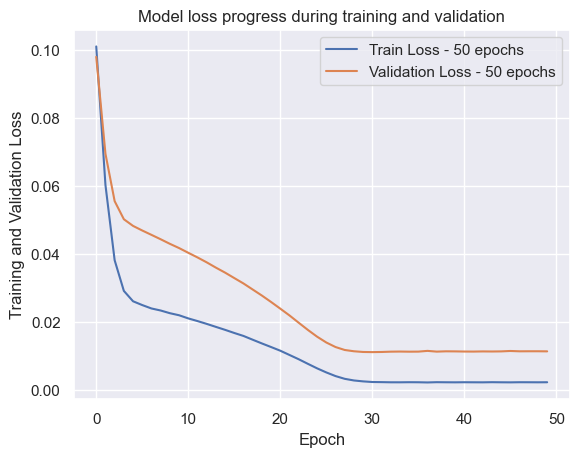

3/3 [==============================] - 0s 2ms/step
Train Score: 29.75 RMSE for 50 epochs
Test Score: 66.79 RMSE for 50 epochs
Training for 100 epochs...
Epoch 1/100
109/109 - 2s - loss: 0.0876 - val_loss: 0.0837 - 2s/epoch - 16ms/step
Epoch 2/100
109/109 - 0s - loss: 0.0490 - val_loss: 0.0583 - 217ms/epoch - 2ms/step
Epoch 3/100
109/109 - 0s - loss: 0.0313 - val_loss: 0.0484 - 213ms/epoch - 2ms/step
Epoch 4/100
109/109 - 0s - loss: 0.0252 - val_loss: 0.0455 - 209ms/epoch - 2ms/step
Epoch 5/100
109/109 - 0s - loss: 0.0234 - val_loss: 0.0442 - 213ms/epoch - 2ms/step
Epoch 6/100
109/109 - 0s - loss: 0.0224 - val_loss: 0.0430 - 205ms/epoch - 2ms/step
Epoch 7/100
109/109 - 0s - loss: 0.0216 - val_loss: 0.0418 - 213ms/epoch - 2ms/step
Epoch 8/100
109/109 - 0s - loss: 0.0209 - val_loss: 0.0405 - 214ms/epoch - 2ms/step
Epoch 9/100
109/109 - 0s - loss: 0.0202 - val_loss: 0.0392 - 211ms/epoch - 2ms/step
Epoch 10/100
109/109 - 0s - loss: 0.0195 - val_loss: 0.0378 - 209ms/epoch - 2ms/step
Epoch 11

Text(0.5, 1.0, 'Model loss progress during training and validation')

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Training and Validation Loss')

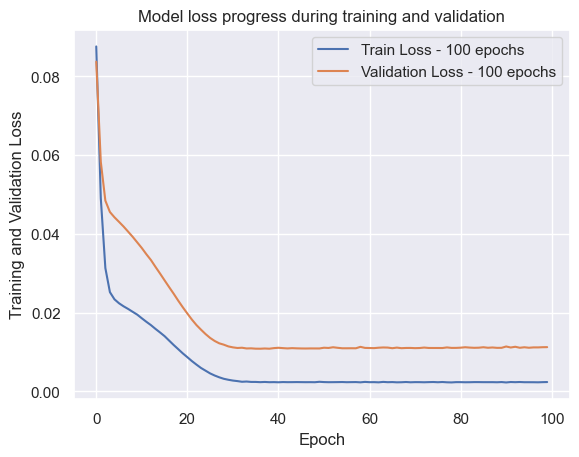

3/3 [==============================] - 0s 2ms/step
Train Score: 29.94 RMSE for 100 epochs
Test Score: 66.30 RMSE for 100 epochs
Training for 300 epochs...
Epoch 1/300
109/109 - 2s - loss: 0.0436 - val_loss: 0.0379 - 2s/epoch - 16ms/step
Epoch 2/300
109/109 - 0s - loss: 0.0177 - val_loss: 0.0263 - 206ms/epoch - 2ms/step
Epoch 3/300
109/109 - 0s - loss: 0.0121 - val_loss: 0.0238 - 205ms/epoch - 2ms/step
Epoch 4/300
109/109 - 0s - loss: 0.0106 - val_loss: 0.0225 - 212ms/epoch - 2ms/step
Epoch 5/300
109/109 - 0s - loss: 0.0098 - val_loss: 0.0212 - 202ms/epoch - 2ms/step
Epoch 6/300
109/109 - 0s - loss: 0.0090 - val_loss: 0.0199 - 205ms/epoch - 2ms/step
Epoch 7/300
109/109 - 0s - loss: 0.0082 - val_loss: 0.0186 - 204ms/epoch - 2ms/step
Epoch 8/300
109/109 - 0s - loss: 0.0074 - val_loss: 0.0174 - 208ms/epoch - 2ms/step
Epoch 9/300
109/109 - 0s - loss: 0.0066 - val_loss: 0.0162 - 207ms/epoch - 2ms/step
Epoch 10/300
109/109 - 0s - loss: 0.0059 - val_loss: 0.0152 - 206ms/epoch - 2ms/step
Epoch 

Text(0.5, 1.0, 'Model loss progress during training and validation')

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Training and Validation Loss')

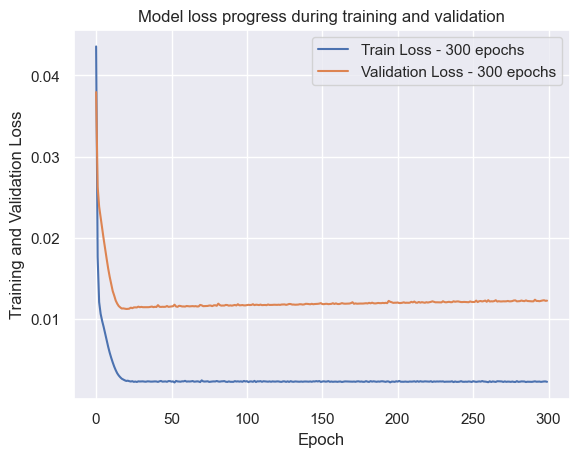

3/3 [==============================] - 0s 2ms/step
Train Score: 29.47 RMSE for 300 epochs
Test Score: 69.30 RMSE for 300 epochs
     Train RMSE  Test RMSE
50    29.753113  66.793758
100   29.942328  66.296977
300   29.465285  69.296792


In [21]:
# Normalize dataset for LSTM
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(df_lstm1['Rate'].values.reshape(-1,1))

# Split into train and test sets
train_size = int(len(dataset) * 0.6)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

# Reshape into X=t and Y=t+1, timestep  look_back
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# Reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

epochs_list = [50, 100, 300]

rmse_results = {}

for epochs in epochs_list:
    print(f'Training for {epochs} epochs...')
    model, history = create_LSTM_model(trainX, trainY, testX, testY, epochs)
    
    # Add the loss for this model to the plot
    plt.plot(history.history['loss'], label=f'Train Loss - {epochs} epochs')
    plt.plot(history.history['val_loss'], label=f'Validation Loss - {epochs} epochs')

    # Configure and show the plot
    plt.title('Model loss progress during training and validation')
    plt.xlabel('Epoch')
    plt.ylabel('Training and Validation Loss')
    plt.legend()
    plt.show();

    # Evalute LSTM Model
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)

    # Invert predictions back to prescaled values
    trainPredict = scaler.inverse_transform(trainPredict)
    trainY_orig = scaler.inverse_transform([trainY])
    testPredict = scaler.inverse_transform(testPredict)
    testY_orig = scaler.inverse_transform([testY])

    # Calculate mean squared error
    trainScore = calculate_RMSE(trainY_orig[0], trainPredict[:,0])
    print(f'Train Score: {trainScore:.2f} RMSE for {epochs} epochs')
    testScore = calculate_RMSE(testY_orig[0], testPredict[:,0])
    print(f'Test Score: {testScore:.2f} RMSE for {epochs} epochs')

    rmse_results[epochs] = {'Train RMSE': trainScore, 'Test RMSE': testScore}

# Convert the dictionary to a DataFrame for easy display
rmse_df = pd.DataFrame(rmse_results).T
print(rmse_df)

# # View how LSTM model fitting to the actual data
# plot_predictions_v1(dataset, trainPredict, testPredict, look_back)
